### Install and Import packages

In [0]:
!pip install geojson tifffile shapely opencv-python

    100% |████████████████████████████████| 112kB 6.2MB/s 
    100% |████████████████████████████████| 1.5MB 9.6MB/s 
  Running setup.py bdist_wheel for tifffile ... - \ | / - done
  Stored in directory: /root/.cache/pip/wheels/22/5b/8e/a9bc85b5dfc1cc91b840b91bfa362a11eeda847d2d4464304e
Successfully built tifffile


In [0]:
import os
import sys
import json
import csv

import matplotlib.pyplot as plt
import numpy as np
import cv2
import tifffile as tiff
import geojson
import shapely
from shapely import wkt

csv.field_size_limit(sys.maxsize)

131072

### Authenticate and Download datasets

In [0]:
import os

from google.colab import auth
from google.colab import drive

auth.authenticate_user()
drive.mount('/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /drive


In [0]:
drive_three_band_dir_path = "/drive/My Drive/4-1/MMI/datasets/dstl/train/three_band" #@param ["/drive/My Drive/4-1/MMI/datasets/dstl/train/three_band", "/drive/My Drive/dstl"] {allow-input: true}
drive_geojson_dir_path = "/drive/My Drive/4-1/MMI/datasets/dstl/train/dstl_train_geojson_v3/train_geojson_v3" #@param ["/drive/My Drive/4-1/MMI/datasets/dstl/train/dstl_train_geojson_v3", "/drive/My Drive/dstl/dstl_train_geojson_v3"] {allow-input: true}
drive_grid_sizes_path = "/drive/My Drive/4-1/MMI/datasets/dstl/train/grid_sizes.csv" #@param ["/drive/My Drive/4-1/MMI/datasets/dstl/train/grid_sizes.csv", "/drive/My Drive/dstl/grid_sizes.csv"] {allow-input: true}
drive_wkt_path = "/drive/My Drive/4-1/MMI/datasets/dstl/train/train_wkt_v4.csv" #@param ["/drive/My Drive/4-1/MMI/datasets/dstl/train/train_wkt_v4.csv", "/drive/My Drive/dstl/train_wkt_v4.csv"] {allow-input: true}

runtime_three_band_dir_path = "/tmp/dstl/three_band" #@param {type:"string"}
runtime_geojson_dir_path = "/tmp/dstl/dstl_train_geojson_v3" #@param {type:"string"}
runtime_grid_sizes_dir_path = "/ tmp/dstl/" #@param {type:"string"}
runtime_grid_sizes_file_name = "grid_sizes.csv" #@param {type:"string"}
runtime_grid_sizes_path = os.path.join(runtime_grid_sizes_dir_path, runtime_grid_sizes_file_name)
runtime_wkt_dir_path = "/ tmp/dstl/" #@param {type:"string"}
runtime_wkt_file_name = "train_wkt_v4.csv" #@param {type:"string"}
runtime_wkt_path = os.path.join(runtime_wkt_dir_path, runtime_wkt_file_name)

os.environ['DRIVE_THREE_BAND_DIR_PATH'] = drive_three_band_dir_path
os.environ['DRIVE_GEOJSON_DIR_PATH'] = drive_geojson_dir_path
os.environ['DRIVE_GRID_SIZES_PATH'] = drive_grid_sizes_path
os.environ['DRIVE_WKT_PATH'] = drive_wkt_path

os.environ['RUNTIME_THREE_BAND_DIR_PATH'] = runtime_three_band_dir_path
os.environ['RUNTIME_GEOJSON_DIR_PATH'] = runtime_geojson_dir_path
os.environ['RUNTIME_GRID_SIZES_DIR_PATH'] = runtime_grid_sizes_dir_path
os.environ['RUNTIME_GRID_SIZES_FILE_NAME'] = runtime_grid_sizes_file_name
os.environ['RUNTIME_GRID_SIZES_PATH'] = runtime_grid_sizes_path
os.environ['RUNTIME_WKT_DIR_PATH'] = runtime_wkt_dir_path
os.environ['RUNTIME_WKT_FILE_NAME'] = runtime_wkt_file_name
os.environ['RUNTIME_WKT_PATH'] = runtime_wkt_path


In [0]:
!ls '/ tmp/dstl'

In [0]:
#copying images to colab (not required for local runtime)
!mkdir -p "$RUNTIME_THREE_BAND_DIR_PATH"
!mkdir -p "$RUNTIME_GEOJSON_DIR_PATH"
!mkdir -p "$RUNTIME_GRID_SIZES_DIR_PATH"
!mkdir -p "$RUNTIME_WKT_DIR_PATH"

!cp "$DRIVE_THREE_BAND_DIR_PATH"/* "$RUNTIME_THREE_BAND_DIR_PATH"
!cp -r "$DRIVE_GEOJSON_DIR_PATH"/* "$RUNTIME_GEOJSON_DIR_PATH"
!cp "$DRIVE_GRID_SIZES_PATH" "$RUNTIME_GRID_SIZES_DIR_PATH"
!cp "$DRIVE_WKT_PATH" "$RUNTIME_WKT_DIR_PATH"



In [0]:
train_img_ids = ["6010_1_2", "6010_4_2", "6010_4_4", "6040_1_0", "6040_1_3", "6040_2_2", "6040_4_4", "6060_2_3", "6070_2_3", "6090_2_0", "6100_1_3", "6100_2_2", "6100_2_3", "6110_1_2", "6110_3_1", "6110_4_0", "6120_2_0", "6120_2_2", "6140_1_2", "6140_3_1", "6150_2_3", "6160_2_1", "6170_0_4", "6170_2_4", "6170_4_1"]


### Function Definitions

In [0]:
def get_scalers(im_size, x_max, y_min):
#     x_max = y_min = None
#     for _im_id, _x, _y in csv.reader(open('/tmp/grid_sizes.csv')):
#         if _im_id == IM_ID:
#             x_max, y_min = float(_x), float(_y)
#             break
  
    h, w = im_size  # they are flipped so that mask_for_polygons works correctly
    w_ = w * (w / (w + 1))
    h_ = h * (h / (h + 1))
    return w_ / x_max, h_ / y_min

def mask_for_polygons(polygons,im_size):
    """Creates mask for polygons of one image"""
    img_mask = np.zeros(im_size, np.uint8)
    if not polygons:
        return img_mask
    int_coords = lambda x: np.array(x).round().astype(np.int32)
    exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
    interiors = [int_coords(pi.coords) for poly in polygons
                 for pi in poly.interiors]
    cv2.fillPoly(img_mask, exteriors, 1)
    cv2.fillPoly(img_mask, interiors, 0)
    return img_mask

def get_image_and_mask(image_id, poly_type,
                       grid_csv=runtime_grid_sizes_path,  ##########can we input these at call time???
                       poly_csv=runtime_wkt_path,
                       image_dir_path=runtime_three_band_dir_path):
    """image_id = ID for the image. eg 6120_2_2
       poly_type = '1' for buildings
                   '2' for _________
                   etc
       grid_csv = path to the csv containing grid sizes
       poly_csv = path to the csv contating polygon information
       image_dir_path = path to three band images directory"""
    
    IM_ID = image_id
    POLY_TYPE = poly_type 


    # Load grid size
    x_max = y_min = None
    for _im_id, _x, _y in csv.reader(open(grid_csv)):
        if _im_id == IM_ID:
            x_max, y_min = float(_x), float(_y)
            break

    # Load train poly with shapely
    train_polygons = None
    for _im_id, _poly_type, _poly in csv.reader(open(poly_csv)):
        if _im_id == IM_ID and _poly_type == POLY_TYPE:
            train_polygons = wkt.loads(_poly)
            break

    # Read image with tiff
    image_file_name = image_id + ".tif"
    image_path = os.path.join(image_dir_path, image_file_name)

    
    im_rgb = tiff.imread(image_path).transpose([1, 2, 0])
    im_size = im_rgb.shape[:2]
    
    x_scaler, y_scaler = get_scalers(im_size, x_max, y_min)


    if train_polygons != None:    
        train_polygons_scaled = shapely.affinity.scale(train_polygons,
                                               xfact=x_scaler, 
                                               yfact=y_scaler, 
                                               origin=(0, 0, 0))
        train_mask = mask_for_polygons(train_polygons_scaled,im_size)
    else:
        train_mask = np.zeros(im_size)
    
    return im_rgb , train_mask



In [0]:
def load_dataset(image_ids,poly_type):
    
    images = []
    masks = []
    for image_id in image_ids:
        x,y = get_image_and_mask(image_id,poly_type=poly_type)

        images.append(x)
        masks.append(y)
    images = np.array(images)
    masks = np.array(masks)
    
    return images,masks


In [0]:
def scale_percentile(matrix):
    w, h, d = matrix.shape
    matrix = np.reshape(matrix, [w * h, d]).astype(np.float64)
    # Get 2nd and 98th percentile
    mins = np.percentile(matrix, 1, axis=0)
    maxs = np.percentile(matrix, 99, axis=0) - mins
    matrix = (matrix - mins[None, :]) / maxs[None, :]
    matrix = np.reshape(matrix, [w, h, d])
    matrix = matrix.clip(0, 1)
    print(w,h,d)
    return matrix

#visualize the loaded images and masks
def show_tif(image,mask):
    """image is a tiff image [height,width,channels]
        mask is the mask for the image with values between 0 and 1. [height,width,channels]"""
    tiff.imshow(255 * scale_percentile(image))
    tiff.imshow(255 * np.stack([mask, mask, mask]))
#     plt.imshow(mask)

### Test

In [0]:
buildings = "1" #buildings
images,masks = load_dataset(train_img_ids,poly_type = buildings)

3349 3391 3


(<matplotlib.figure.Figure at 0x7fe1812e7780>,
 <matplotlib.image.AxesImage at 0x7fe18129cef0>)

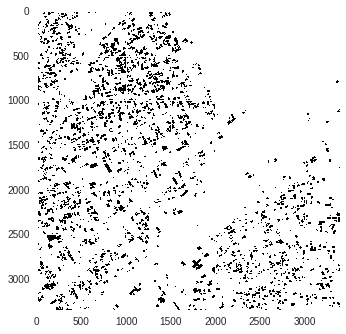

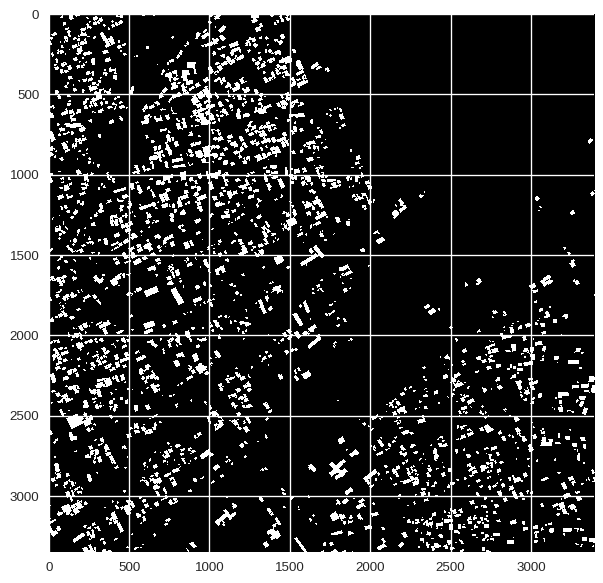

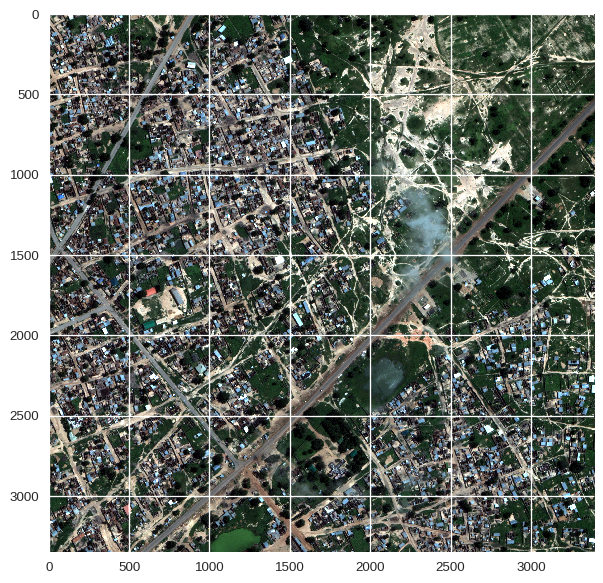

In [0]:
tiff.imshow(255 * np.stack([masks[10], masks[10], masks[10]]))
tiff.imshow(255 * scale_percentile(images[10]))

In [0]:
import pickle as pkl
with open("dstl_images.pkl","wb") as f:
    pkl.dump(images,f)

In [0]:
!cp dstl_images.pkl "/drive/My Drive/4-1/MMI/datasets/dstl/train"

1
3349 3396 3
2
3349 3396 3
3
3349 3396 3
4
3349 3396 3
5
3349 3396 3
6
3349 3396 3
7
3349 3396 3
8
3349 3396 3
9
3349 3396 3
10
3349 3396 3


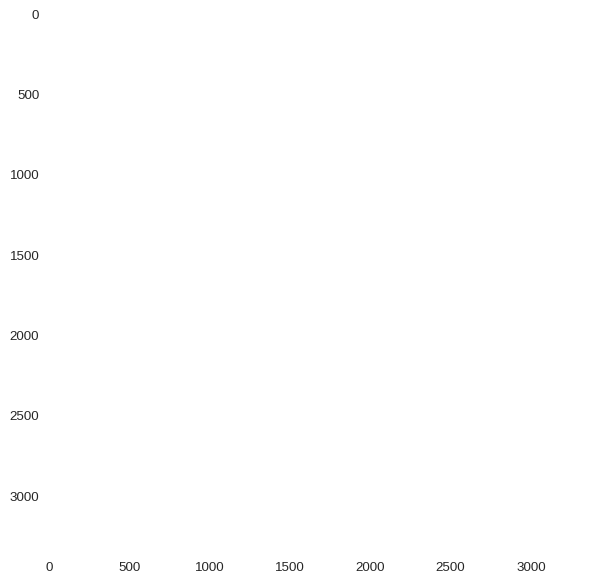

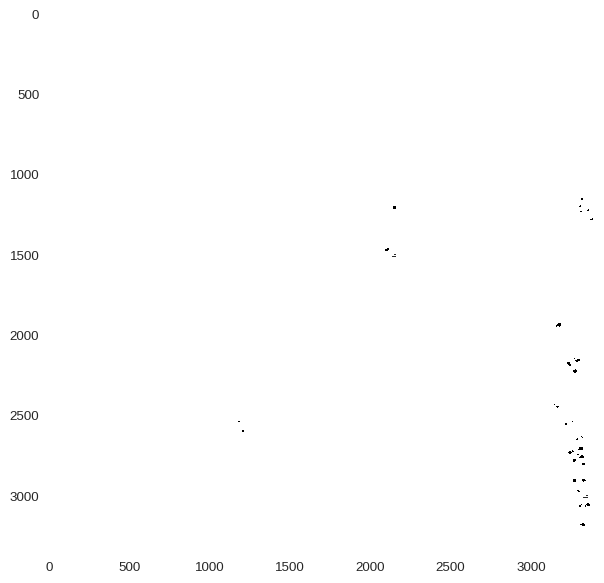

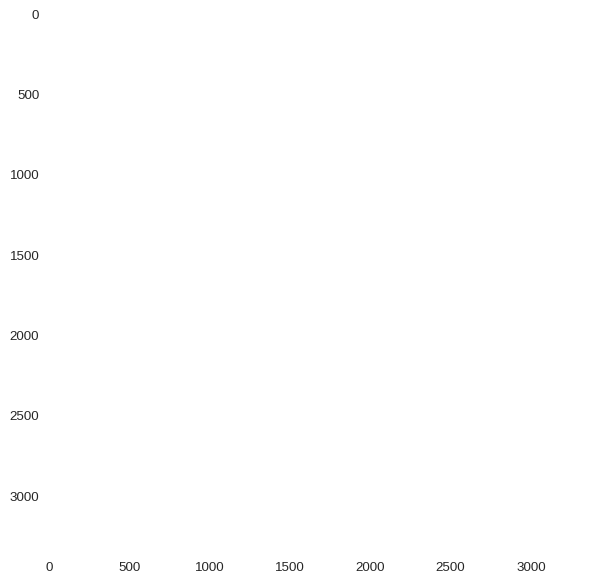

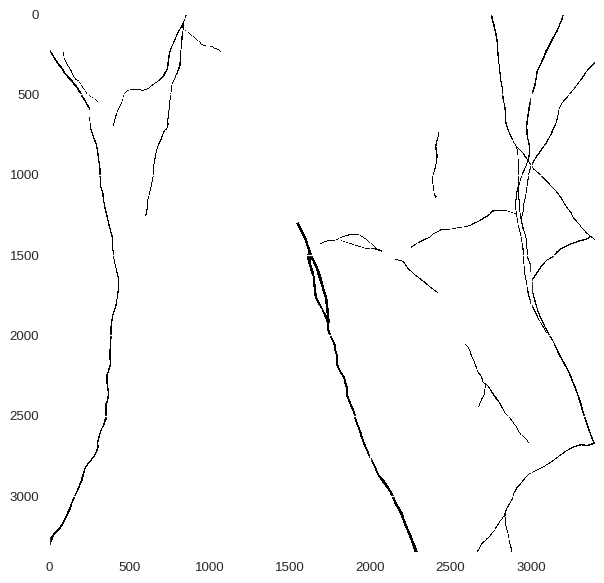

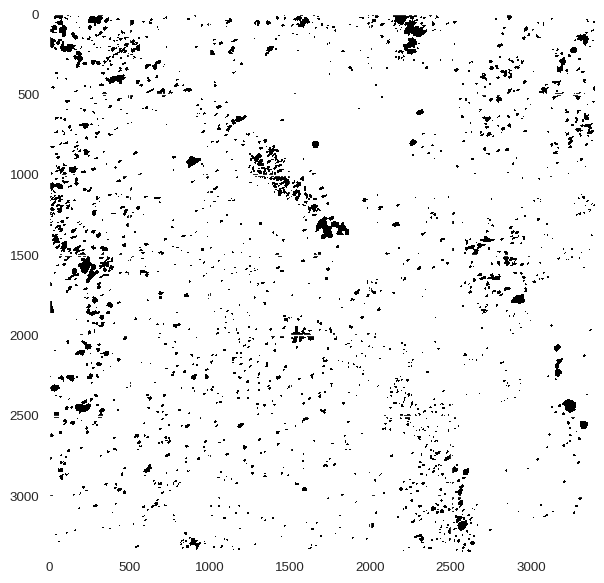

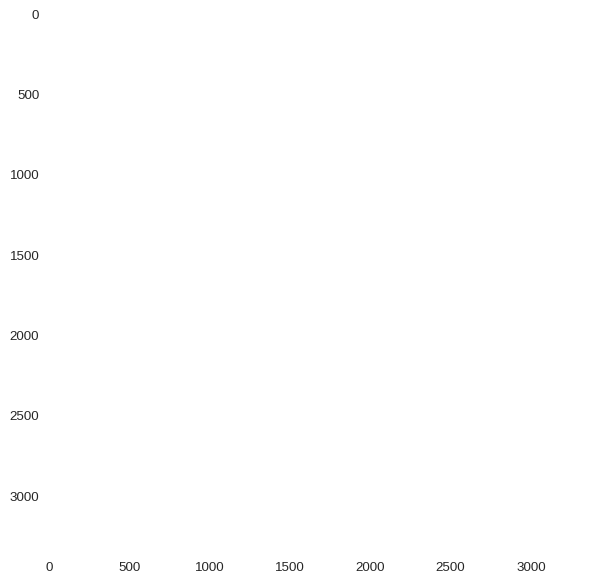

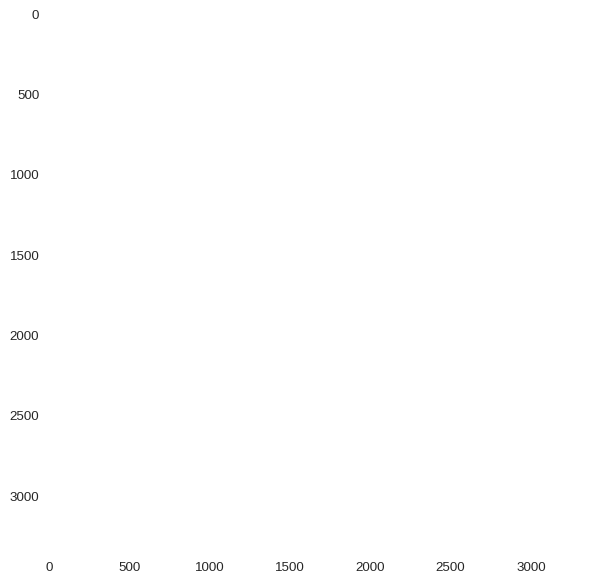

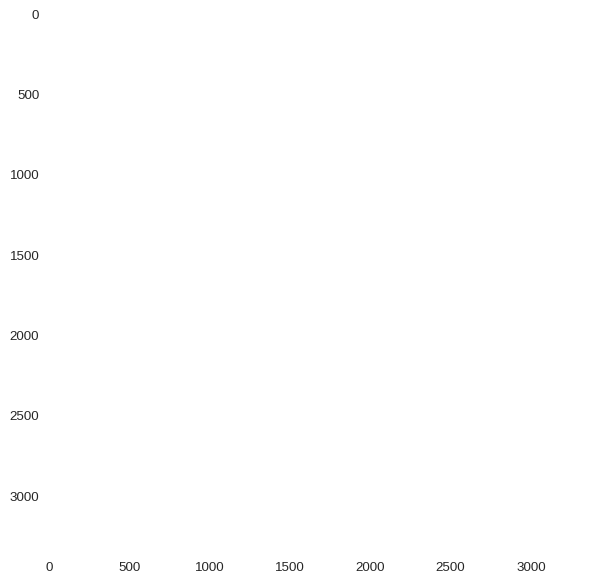

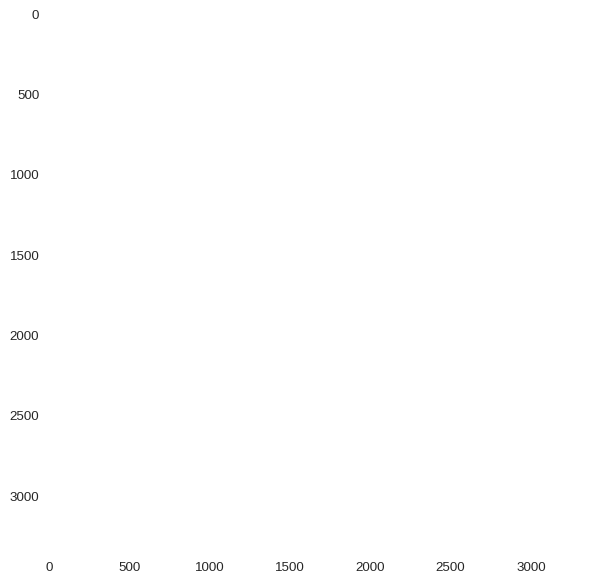

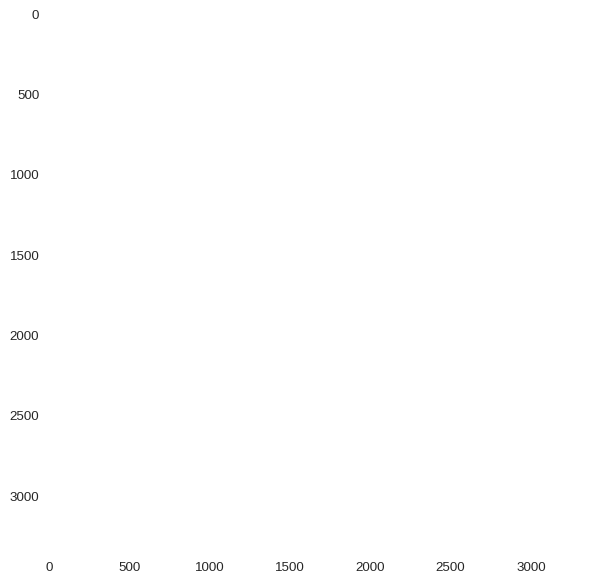

In [0]:
import os

for i in range(1,11):
    print(i)
    
    poly_type = str(i)
    images, masks = load_dataset(train_img_ids,poly_type)

    pickle_file_name = "dstl_masks_" + poly_type + ".pkl"
    with open(pickle_file_name, "wb") as f:
        pkl.dump(masks, f)

    os.environ['MASK_FILENAME'] = pickle_file_name
        
    !cp $MASK_FILENAME "/drive/My Drive/4-1/MMI/datasets/dstl/train"
#     !echo $MASK_FILENAME
    